# Comparison of Optimization algorithms

I took last semester a course on optimization algorithms, where we prove how many steps does each algorithm need to converge to an epsilon error. However the course was pure theory and I would like to see if this is mathematical prrofs apply in practice.

The algorithms can be clustered as follows: <br>
<ol>
    <li> First order methods </li>
    <li> Second order and quasi newton methods</li>
    <li> Coordinate based methods </li>
    <li> Constrained optimization algorithms </li>
</ol>

The function that we are going to work with is the least squares problem , which is widely used in ML these days. The function is characterized by <br>:
$$f(x) = \frac{1}{2n} \sum_{i=1}^{n} (a_i^\top x - b_i)^2 = \frac{1}{2n} \|Ax - b\|^2 $$

where A is the data matrix and b is a bias vector

In [1]:
import numpy as np
from optimizers.firstOrder import First_Order_Optimizer
from optimizers.secondOrder import Second_Order_Optimizer
from optimizers.coordinate import Coordinate_Based_Optimizers
from optimizers.constrained import Constrained_Optimizers
from math import sqrt
import matplotlib.pyplot as plt

# DATA GENERATION

In [2]:
def generate_data_bias(dimension,mean,std_dev):
    A = np.random.uniform(mean,std_dev,(dimension,dimension))
    b = np.random.uniform(mean,std_dev,dimension)
    return A,b

In [3]:
A,b = generate_data_bias(1000,0,1)

In [4]:
print("Data matrix dimension = {} and bias vector dimension {}".format(A.shape,b.shape))

Data matrix dimension = (1000, 1000) and bias vector dimension (1000,)


# Function Properties

### Computing Smoothness

$f(x)$ is smooth with $L = \frac1n\|A\|^2$ 

In [5]:
def computing_function_smoothness(A):
    N = A.shape[0]
    return (1/N) * np.linalg.norm(A,2)

### Computing Lipshitz constant

Lipschitz constant $\|\nabla f(x)\| \leq \frac{1}{n} (\|A^\top A\|\|x\| + \|A^\top Ab\|)$

In [6]:
def lipshitz_gradient_constant(A,x,b):
    N = A.shape[0]
    lipshitz_cnst = (np.linalg.norm(np.dot(A.T,A),2) * np.linalg.norm(x,2)) + (np.linalg.norm(np.dot(np.dot(A.T,A),b),2))
    return 1/N * lipshitz_cnst

# PLOTS

In [7]:
def plot_loss(losses,method_name):
    
    iterations = np.arange(0,len(losses))
    plt.plot(iterations,losses)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(method_name + ' performance')
    plt.show()

# BOUNDED GRADIENTS

Based on theoretical analysis by bounding the gradients : $$ \|\nabla(x)\|^2 < L $$ and $$ \|x_0 - x^*\|^2 <R $$ 

For simplicity assume that R = 25. This yields the following theoretical result:

                        Algorithm Step Size Number of steps
    ------------------ | -------------------------| -------------
    GD                 | $$\frac{R}{L\sqrt{T}}$$  | $$ O(\frac{1}{\epsilon^2}) $$
    SGD                | $$\frac{R}{B\sqrt{T}}$$  | $$ O(\frac{1}{\epsilon^2}) $$
    Mini batch         | $$\frac{R}{B\sqrt{T}}$$  | $$ O(\frac{1}{\epsilon^2}) $$

In [8]:
epsilon = 0.00001
R = 25
L = computing_function_smoothness(A)
max_iters = 100

In [21]:
# sgd  / gd / mini batch
gamma = (R / (L * sqrt(max_iters))) * (0.0001)
batches = [1,100,A.shape[0]]
models_loss = []
for batch in batches:
    sgdOptimizer = First_Order_Optimizer(batch_size=batch,epsilon=epsilon,learning_rate=gamma,max_iters= max_iters)
    _,losses = sgdOptimizer.mini_batch_stochastic_gradient_descent(A,b)
    models_loss.append(losses)

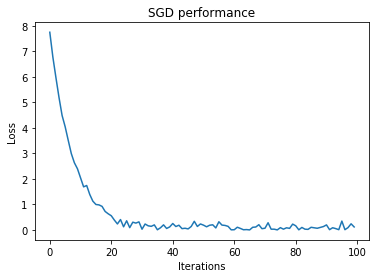

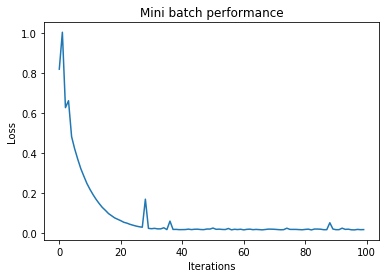

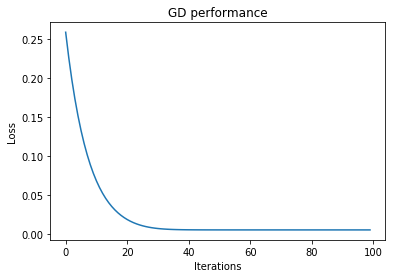

In [22]:
models_names = ['SGD','Mini batch','GD']
for i in range(0,len(models_loss)):
    plot_loss(models_loss[i],models_names[i])

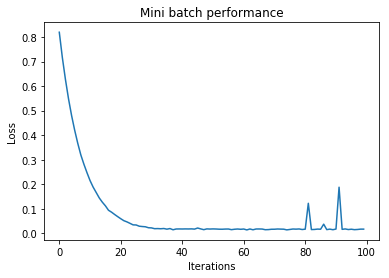

In [20]:
plot_loss(losses_mb,'Mini batch')

# LIPSHITZ CONTINUIOS GRADIENTS

# STRONG CONVEXITY